Group 2220  
Daniel  
Theivan  
Marco  
Jake  

# Exercise 3, CNN, question 2 and 3

# Initial Set-Up

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

L=60
input_shape = (L, 1)
n_class = 3
BATCH_SIZE = 250
EPOCHS = 100
accuracy_1 =[]

def Show_data(x,L,s="data"):
    plt.plot(np.arange(L),x[0])
    plt.plot(np.arange(L,2*L),x[1])
    plt.plot(np.arange(2*L,3*L),x[2])
    plt.title(s)
    plt.xlabel("time")
    plt.show()
    
def Show_weights(model,l=0,label="model"):
    c=['r','y','c','b','m'] #colori
    m=['o','s','D','<','>'] #markers
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

def build_modelJ():
    reg = tf.keras.regularizers.l2(0.2) ## raised to 0.2
    #reg = regularizers.l1(0.1)
    ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, 
                                            seed=None)
    NF = 5
    # challenge: at most 600 tunable parameters
    model = Sequential()
    # -----2-----
    model.add(Conv1D(filters=NF, kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(n_class, activation='softmax'))
    opt = tf.keras.optimizers.Adam()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,metrics=['accuracy'])
    return model

def build_model(init='normal', reg='l2', lmb=0.2):
    #Initializers
    if init=='zeros':
        ini=tf.keras.initializers.Zeros()
    elif init=='ones':
        ini=tf.keras.initializers.Ones()
    elif init=='normal':
        ini=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
    else:
        print('Error Initializers')
    #Regularizers
    if reg=='l1':
        rer=tf.keras.regularizers.l1(lmb)
    elif reg=='l2':
        reg=tf.keras.regularizers.l2(lmb)
    elif reg=='l1_l2':
        reg=tf.keras.regularizers.l1_l2(lmb, lmb)
    else:
        print('Error Regularizers')
    # challenge: at most 600 tunable parameters
    model = Sequential()
    model.add(Conv1D(filters=5, kernel_size=11, 
                     kernel_initializer=ini, # ini - ini_0 - ini_1
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_class, activation='softmax')) # softmax !    --->n_class=3 : Multiclassification
    opt = tf.keras.optimizers.Adam()
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,metrics=['accuracy'])
    return model

##################################################################################################

jump = lambda drift, stdev: int(np.random.normal(drift,stdev))

def pattern(i,z,a):
    p = a*np.sin((np.pi*i)/z)
    return p.astype(int) #Use numpy convesion instead it aviods "IOPub data rate exceeded"

def gen_data(A=500): #Generate datasets with varying A     
    np.random.seed(12345)
    Z=12 # Z=nr of steps
    N=10000  # number of data samples
    L=60 # size of each sample of the timeseries 
    DX = 50  # step parameters: introduce small positive bias 
    bias = 5

    y = [0] * N
    x = [[0] * L for i in range(N)] 
    for i in range(N):
        if i>0:
            x[i][0] = x[i-1][-1] + jump(bias,DX)
        for j in range(1,L):
            x[i][j] = x[i][j-1] + jump(bias,DX)  
        y[i] = i%3 
        if y[i]>0:
            j0 = np.random.randint(0,L-1-Z)
            sign = 3-2*y[i]
            for j in range(Z):
                x[i][j0+j] += sign*pattern(j,Z,A)
    return np.asarray(x), np.asarray(y)

def prep_data(x,y):
    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]

    x = x/400
    
    #spliting of training and validation 
    perc_train=0.8 
    N_train = int(perc_train*N)
    x_train = x[:N_train]
    y_train = y[:N_train]
    x_val = x[N_train:]
    y_val = y[N_train:]

    # Keras wants an additional dimension with a 1 at the end
    x_train = x_train.reshape(x_train.shape[0], L, 1)
    x_val =  x_val.reshape(x_val.shape[0], L, 1)
    input_shape = (L, 1)
    return x_train, y_train, x_val, y_val, input_shape

def show_confusion_matrix(validations, predictions, label="Model"):
    LABELS = ["absent","positive","negative"]
    cmap="GnBu"
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    seaborn.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def Show_history(fit, label =''):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.set_title(label+'')
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.set_title(label+' Loss ')
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

# 2 Signal Amplitude

With a greater amplitude for the sine pattern that is injected into the samples we are increasing the signal to noise ratio. This should make it easier for the CNN to detect the pattern. Here the intention is to quantify the effect.

In [ ]:
Amplitudes  =[0,50,100,150,200,250,300,350,400,450,500,550,600,650,700,800]
model = build_modelJ()

for A in Amplitudes:
    print('A = ', A)
    x, categ = gen_data(A)
    n_class = 3
    N,L = len(x), len(x[0])
    y = np.zeros((N,n_class))
    for i in range(N):
        y[i][categ[i]] = 1. #prof does it here but might add to gen_data 
    x_train, y_train, x_val, y_val, input_shape = prep_data(x,y)
    fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=0, shuffle=True)  
    
    loss1, acc1 = model.evaluate(x=x_val, y=y_val, verbose = 0)
    accuracy_1.append(acc1)
    y_pred_val = model.predict(x_val)
    # Take the class with the highest probability from the val predictions
    max_y_pred_val = np.argmax(y_pred_val, axis=1)
    max_y_val = np.argmax(y_val, axis=1)

    #show_confusion_matrix(max_y_val, max_y_pred_val, label="Model 1, A = "+str(A))
    
print(accuracy_1)

A =  0
A =  50
A =  100
A =  150
A =  200
A =  250
A =  300
A =  350
A =  400
A =  450


In [ ]:
fig, ax =plt.subplots(1,1,figsize=(8,8))

ax.plot(Amplitudes, accuracy_1, label ="Model 1")
#ins = ax.inset_axes([0.57,0.18,0.4,0.4])
ax.set_xlabel("Amplitude, A")
ax.set_ylabel("Validation Accuracy")
plt.show()

### Results

This plot show that signal amplitude has a significant effect on the accuracy. With too low an amplitude the model is reduced to a random guess. With a high amplitude the model can get near perfect performance.

# Regularisation Tuning

Regularisation restricts the size of the weights, thus the weights are less flexible and cannot fit the training data as well. This however means the model is more likley to follow the trend of the entire population. Thus regularisation can help validation accuracy improve. With too much regularisation the weights are too restriced and they can't fit the training data very well at all and thus don't follow the trend of the population either. Too much regularisation can make the validation accuracy worse.

To achieve regularisation the function that guides the gradient descent is a compination of the cost function and a regularisation function. The parameter D tunes the amount of regularisation. With smaller D there is more regularisation. 

argmin($D$ Cost + Regularisation)

There are multiple possible choices for the regularisation function. The three ones provided by keras are tested l1,l2 and l1_l2.

How to find the best combination of parameters? Well with a grid search of course...

### Read the data

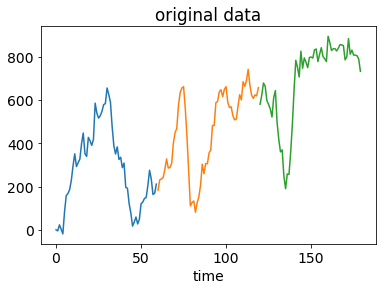

data:  10000


In [4]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0]) #10000 60
Show_data(x,L,"original data")
categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)
y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

### Split and Rescale the data

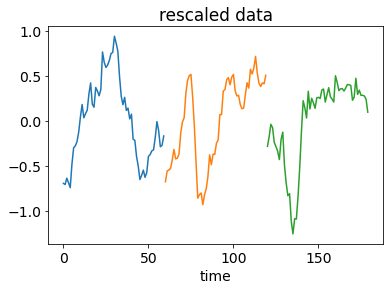

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [5]:
#OPTIOIN 1----- 
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]
x_scaled = x/400
Show_data(x_scaled,L,"rescaled data") 

perc_train=0.8
N_train = int(perc_train*N)
x_train = x_scaled[:N_train]
y_train = y[:N_train]
x_val = x_scaled[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)
# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1) #shape: (8000,60,1 aggiuntiva)
x_val =  x_val.reshape(x_val.shape[0], L, 1) #shape: (2000,60,1 aggiuntiva)
input_shape = (L, 1)

### Perform the GridSearch 

In [6]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
BATCH_SIZE = 250
EPOCHS = 50
parameters = {
                'reg':['l1', 'l2', 'l1_l2'],
                'lmb':[0, 1e-1, 1e-3, 1e-5]
             }

model_gridsearch = KerasClassifier(build_fn = build_model, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
grid = GridSearchCV(estimator=model_gridsearch, param_grid=parameters, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train)

ModuleNotFoundError: No module named 'sklearn'

### Results

The best result was using l1_l2 regularisation function with a D value of 1e-5. 

In [ ]:
# summarize results
print("\n\nBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

### Weight Check

If the training is going perfectly we would expect 1 filter to be able to detect the positive sine() one for the negative sign() and the others to collaps to 0. The other can collaps to 0 as they are not needed to classify the samples and so simply by not firing they help the most.

The model will be trained using the best regularisation parameter found and the weights will be plotted.

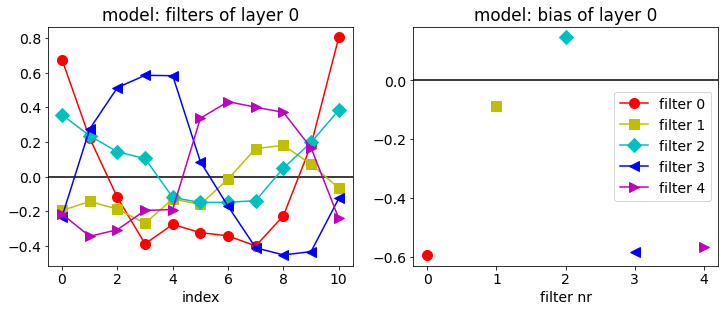

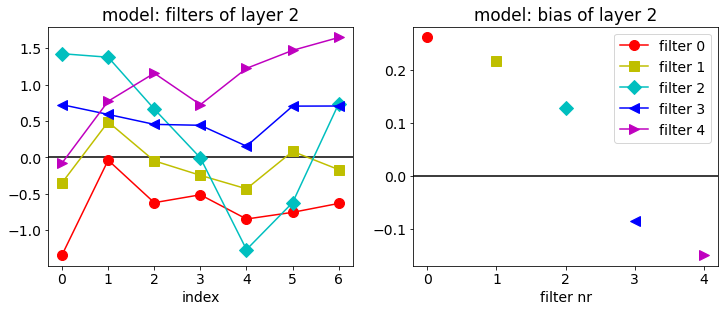

In [7]:
bestmodel = build_model(reg = 'l1_l2', lmb = 1e-5)

fit = bestmodel.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=0, shuffle=True)

Show_weights(bestmodel,0)
Show_weights(bestmodel,2)

### Results

The weights don't show any improvement towards our expectations.